In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [2]:
full_data=pd.concat(map(pd.read_csv,['/Users/manishkumar/Downloads/Sales_January_2019.csv','/Users/manishkumar/Downloads/Sales_February_2019.csv',
                                     '/Users/manishkumar/Downloads/Sales_March_2019.csv','/Users/manishkumar/Downloads/Sales_April_2019.csv',
                                     '/Users/manishkumar/Downloads/Sales_May_2019.csv','/Users/manishkumar/Downloads/Sales_June_2019.csv',
                                     '/Users/manishkumar/Downloads/Sales_July_2019.csv','/Users/manishkumar/Downloads/Sales_August_2019.csv',
                                     '/Users/manishkumar/Downloads/Sales_September_2019.csv','/Users/manishkumar/Downloads/Sales_October_2019.csv',
                                     '/Users/manishkumar/Downloads/Sales_November_2019.csv','/Users/manishkumar/Downloads/Sales_December_2019.csv']))


In [3]:
full_data.head(5)

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,141234,iPhone,1,700,01/22/19 21:25,"944 Walnut St, Boston, MA 02215"
1,141235,Lightning Charging Cable,1,14.95,01/28/19 14:15,"185 Maple St, Portland, OR 97035"
2,141236,Wired Headphones,2,11.99,01/17/19 13:33,"538 Adams St, San Francisco, CA 94016"
3,141237,27in FHD Monitor,1,149.99,01/05/19 20:33,"738 10th St, Los Angeles, CA 90001"
4,141238,Wired Headphones,1,11.99,01/25/19 11:59,"387 10th St, Austin, TX 73301"


In [4]:
full_data.duplicated().sum()
full_data.drop_duplicates(inplace=True)
full_data.describe()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
count,185687,185687,185687,185687,185687,185687
unique,178438,20,10,24,142396,140788
top,160873,USB-C Charging Cable,1,11.95,12/15/19 20:16,"193 Forest St, San Francisco, CA 94016"
freq,5,21859,168291,21859,8,9


In [5]:
full_data.dropna(inplace=True)
full_data.isnull().sum()

Order ID            0
Product             0
Quantity Ordered    0
Price Each          0
Order Date          0
Purchase Address    0
dtype: int64

In [6]:
full_data[['Order ID','Product','Quantity Ordered', 'Price Each', 'Order Date','Purchase Address']]
full_data[['Purchase Address', 'City','State']]=full_data['Purchase Address'].str.split(',',n=2,expand=True)
full_data.tail()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,City,State
25112,319666,Lightning Charging Cable,1,14.95,12/11/19 20:58,14 Madison St,San Francisco,CA 94016
25113,319667,AA Batteries (4-pack),2,3.84,12/01/19 12:01,549 Willow St,Los Angeles,CA 90001
25114,319668,Vareebadd Phone,1,400,12/09/19 06:43,273 Wilson St,Seattle,WA 98101
25115,319669,Wired Headphones,1,11.99,12/03/19 10:39,778 River St,Dallas,TX 75001
25116,319670,Bose SoundSport Headphones,1,99.99,12/21/19 21:45,747 Chestnut St,Los Angeles,CA 90001


In [7]:
full_data['Pin Code']=full_data['State'].str.split(' ',expand=True)[2]
full_data['State']=full_data['State'].str.split(' ',expand=True)[1]
full_data.tail()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,City,State,Pin Code
25112,319666,Lightning Charging Cable,1,14.95,12/11/19 20:58,14 Madison St,San Francisco,CA,94016
25113,319667,AA Batteries (4-pack),2,3.84,12/01/19 12:01,549 Willow St,Los Angeles,CA,90001
25114,319668,Vareebadd Phone,1,400,12/09/19 06:43,273 Wilson St,Seattle,WA,98101
25115,319669,Wired Headphones,1,11.99,12/03/19 10:39,778 River St,Dallas,TX,75001
25116,319670,Bose SoundSport Headphones,1,99.99,12/21/19 21:45,747 Chestnut St,Los Angeles,CA,90001


In [8]:
full_data.dtypes

Order ID            object
Product             object
Quantity Ordered    object
Price Each          object
Order Date          object
Purchase Address    object
City                object
State               object
Pin Code            object
dtype: object

In [9]:
full_data['Quantity Ordered']=pd.to_numeric(full_data['Quantity Ordered'],errors='coerce')
full_data['Price Each']=pd.to_numeric(full_data['Price Each'],errors='coerce')
total_order=full_data.groupby('Product')['Quantity Ordered'].sum()

In [10]:
new_data=full_data.copy()
new_data['Order Date']=pd.to_datetime(new_data['Order Date'],errors='coerce')
new_data['Order Date']=new_data['Order Date'].dt.date
perday_order=new_data.groupby(['Order Date','Product'])['Quantity Ordered'].sum().reset_index()
perday_order

,Order Date,Product,Quantity Ordered
0,2019-01-01,20in Monitor,4.0
1,2019-01-01,27in 4K Gaming Monitor,7.0
2,2019-01-01,27in FHD Monitor,8.0
3,2019-01-01,34in Ultrawide Monitor,18.0
4,2019-01-01,AA Batteries (4-pack),33.0
...,...,...,...
6822,2020-01-01,ThinkPad Laptop,2.0
6823,2020-01-01,USB-C Charging Cable,4.0
6824,2020-01-01,Vareebadd Phone,1.0
6825,2020-01-01,Wired Headphones,4.0


In [11]:
perday_order['Year']=pd.DatetimeIndex(perday_order['Order Date']).year
perday_order=perday_order.loc[perday_order['Year']!=2020]
perday_order.drop(columns=['Year'])

,Order Date,Product,Quantity Ordered
0,2019-01-01,20in Monitor,4.0
1,2019-01-01,27in 4K Gaming Monitor,7.0
2,2019-01-01,27in FHD Monitor,8.0
3,2019-01-01,34in Ultrawide Monitor,18.0
4,2019-01-01,AA Batteries (4-pack),33.0
...,...,...,...
6807,2019-12-31,ThinkPad Laptop,26.0
6808,2019-12-31,USB-C Charging Cable,103.0
6809,2019-12-31,Vareebadd Phone,10.0
6810,2019-12-31,Wired Headphones,89.0


In [12]:
perday_quantity=perday_order.groupby(['Order Date'])['Quantity Ordered'].sum().reset_index()
perday_quantity

,Order Date,Quantity Ordered
0,2019-01-01,343.0
1,2019-01-02,367.0
2,2019-01-03,330.0
3,2019-01-04,329.0
4,2019-01-05,355.0
...,...,...
360,2019-12-27,867.0
361,2019-12-28,928.0
362,2019-12-29,953.0
363,2019-12-30,925.0


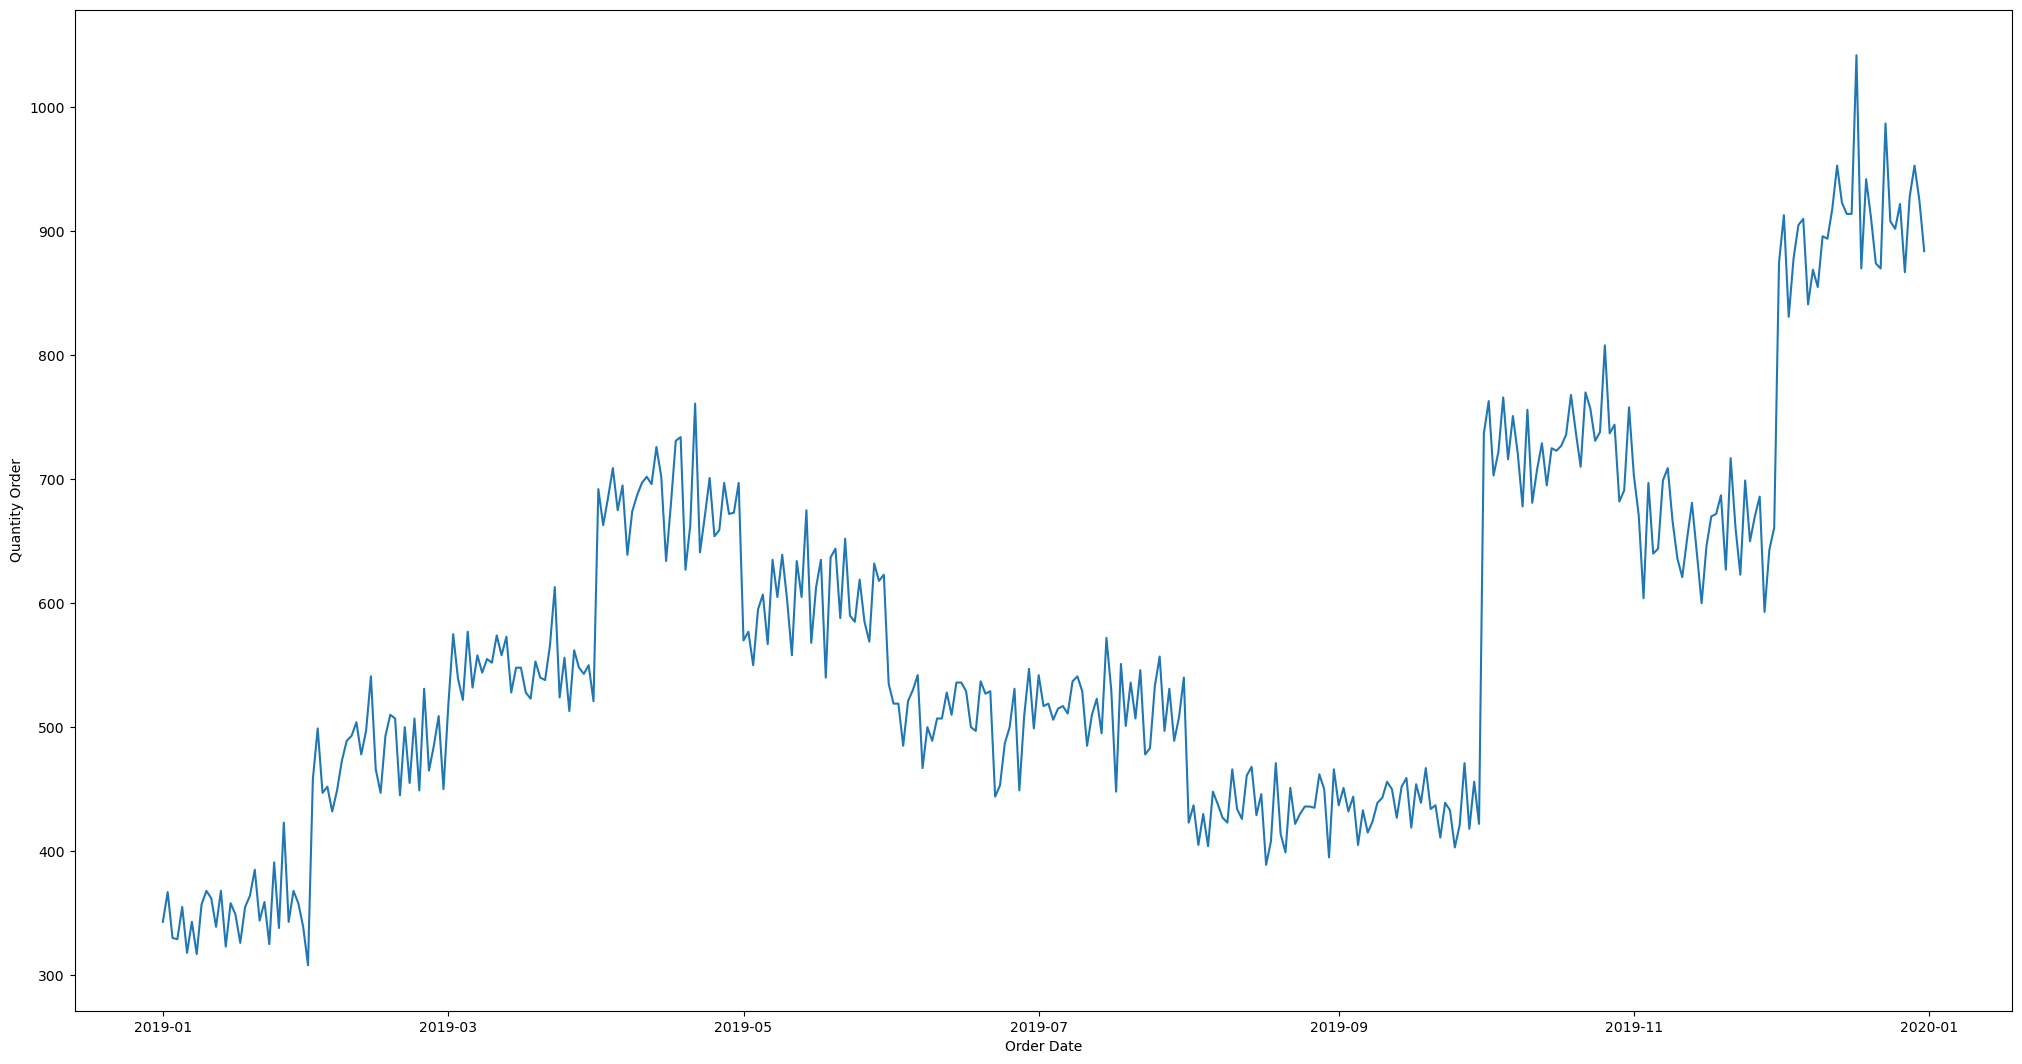

In [13]:
plt.figure(figsize=(25,13))
plt.plot(perday_quantity['Order Date'],perday_quantity['Quantity Ordered'])
plt.xlabel('Order Date')
plt.ylabel('Quantity Order')
plt.show()

# Sales Lag

In [14]:
df_diff=perday_quantity.copy()
df_diff['prev sales']=df_diff['Quantity Ordered'].shift(1)
df_diff=df_diff.dropna()
df_diff['diff']=df_diff['Quantity Ordered']-df_diff['prev sales']
df_diff.sort_values('Order Date')

,Order Date,Quantity Ordered,prev sales,diff
1,2019-01-02,367.0,343.0,24.0
2,2019-01-03,330.0,367.0,-37.0
3,2019-01-04,329.0,330.0,-1.0
4,2019-01-05,355.0,329.0,26.0
5,2019-01-06,318.0,355.0,-37.0
...,...,...,...,...
360,2019-12-27,867.0,922.0,-55.0
361,2019-12-28,928.0,867.0,61.0
362,2019-12-29,953.0,928.0,25.0
363,2019-12-30,925.0,953.0,-28.0


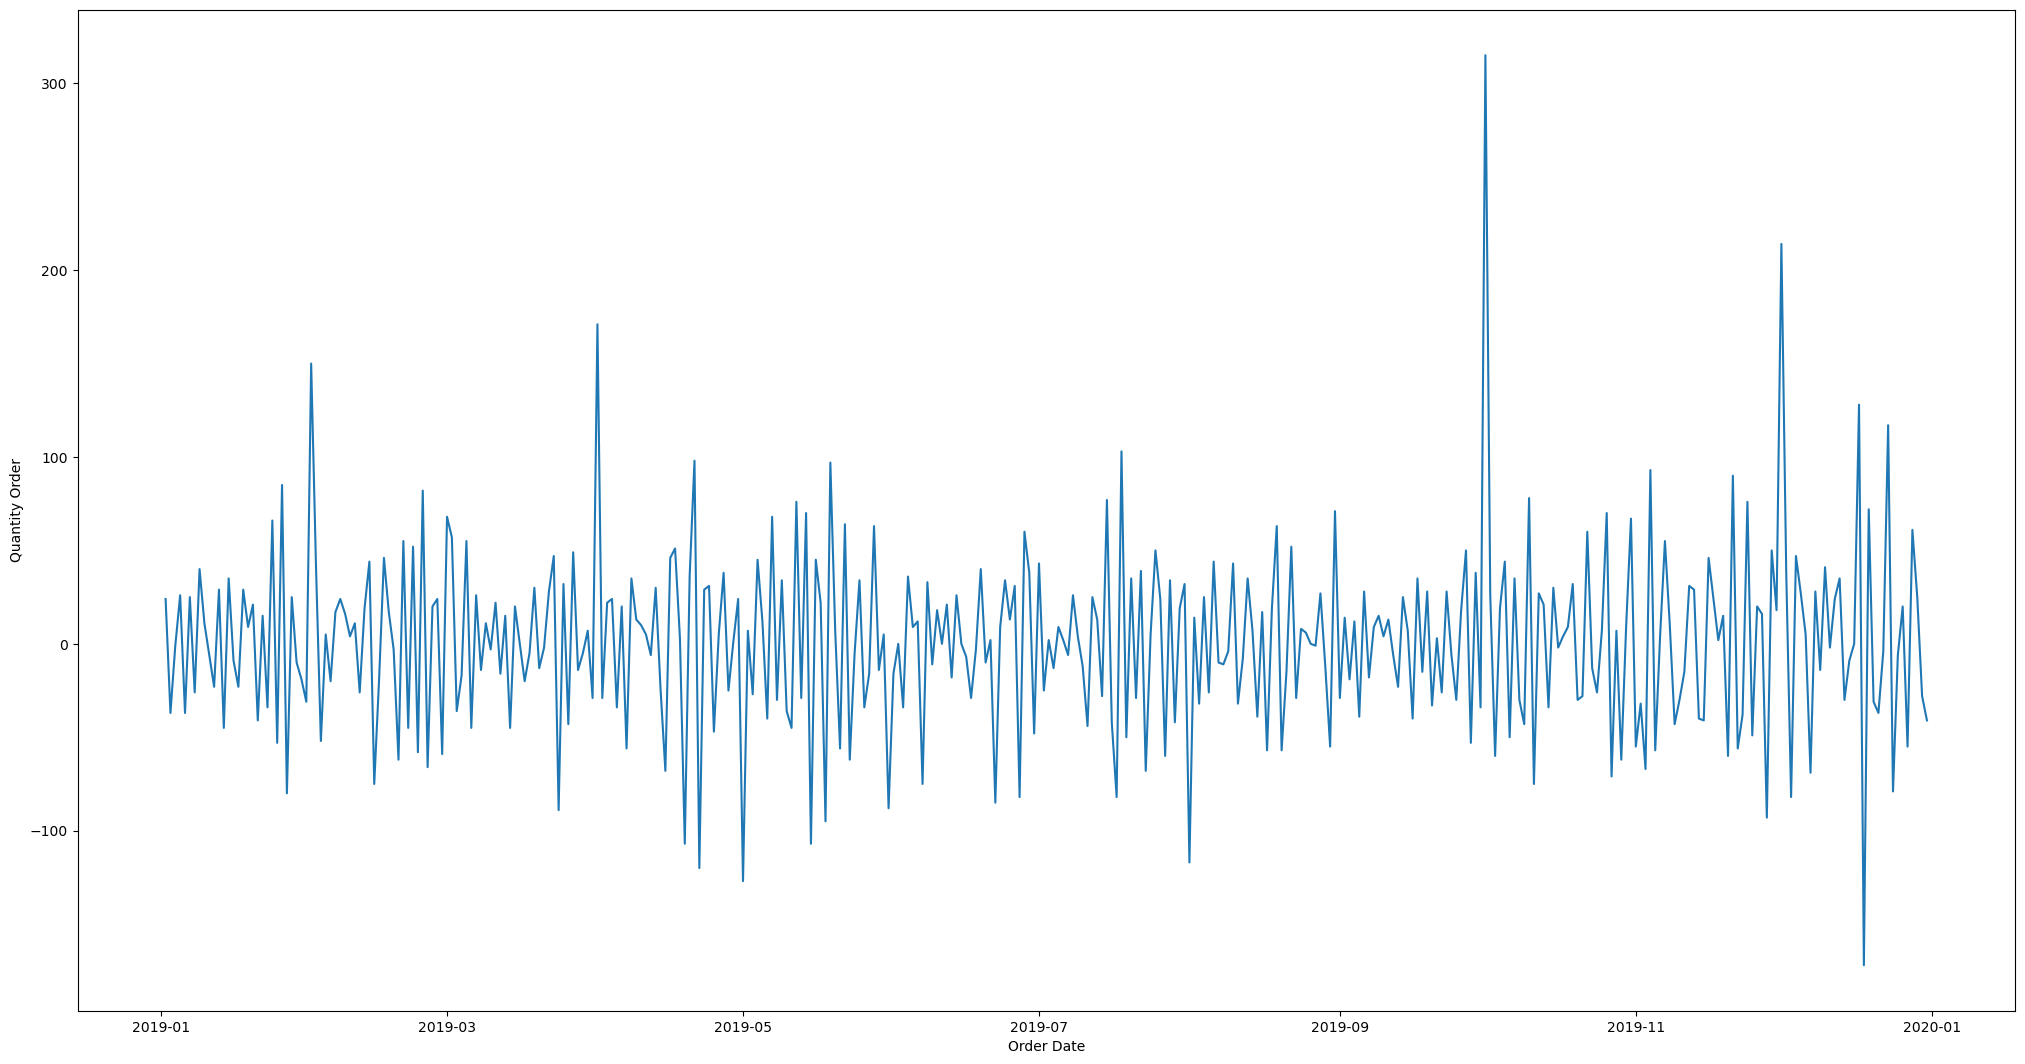

In [15]:
plt.figure(figsize=(25,13))
# sns.lineplot(data,x="BHK",y="Price",palette="muted")
plt.plot(df_diff['Order Date'],df_diff['diff'])
plt.xlabel('Order Date')
plt.ylabel('Quantity Order')
plt.show()

In [16]:
full_data['Order Date']=pd.to_datetime(full_data['Order Date'],errors='coerce')
df=full_data.groupby(['Order Date'])['Quantity Ordered'].sum().reset_index()
df['Year']=pd.DatetimeIndex(df['Order Date']).year
df_2020=df.loc[df['Year']==2020]
df=df.loc[df['Year']!=2020]
df=df.drop(columns=['Year'])
df= df.set_index('Order Date')
df.index=pd.to_datetime(df.index).floor('H').to_pydatetime() 
df=df.groupby(df.index)['Quantity Ordered'].sum().reset_index()
df= df.set_index('index').rename_axis('Date')

df.index = pd.to_datetime(df.index)
df.index

DatetimeIndex(['2019-01-01 03:00:00', '2019-01-01 04:00:00',
               '2019-01-01 05:00:00', '2019-01-01 06:00:00',
               '2019-01-01 07:00:00', '2019-01-01 08:00:00',
               '2019-01-01 09:00:00', '2019-01-01 10:00:00',
               '2019-01-01 11:00:00', '2019-01-01 12:00:00',
               ...
               '2019-12-31 14:00:00', '2019-12-31 15:00:00',
               '2019-12-31 16:00:00', '2019-12-31 17:00:00',
               '2019-12-31 18:00:00', '2019-12-31 19:00:00',
               '2019-12-31 20:00:00', '2019-12-31 21:00:00',
               '2019-12-31 22:00:00', '2019-12-31 23:00:00'],
              dtype='datetime64[ns]', name='Date', length=8627, freq=None)

# Feature Creation

In [17]:

def create_features(df):
    df['dayofweek']=df.index.dayofweek
    df['hour']=df.index.hour
    df['quarter']=df.index.quarter
    df['month']=df.index.month
    df['year']=df.index.year
    return df
df=create_features(df)

In [18]:
df_hour = df.groupby('hour')['Quantity Ordered'].sum().reset_index()
df_month = df.groupby('month')['Quantity Ordered'].sum().reset_index()
df_dayofweek = df.groupby('dayofweek')['Quantity Ordered'].sum().reset_index()
df_quarter = df.groupby('quarter')['Quantity Ordered'].sum().reset_index()

# Hourly Sales

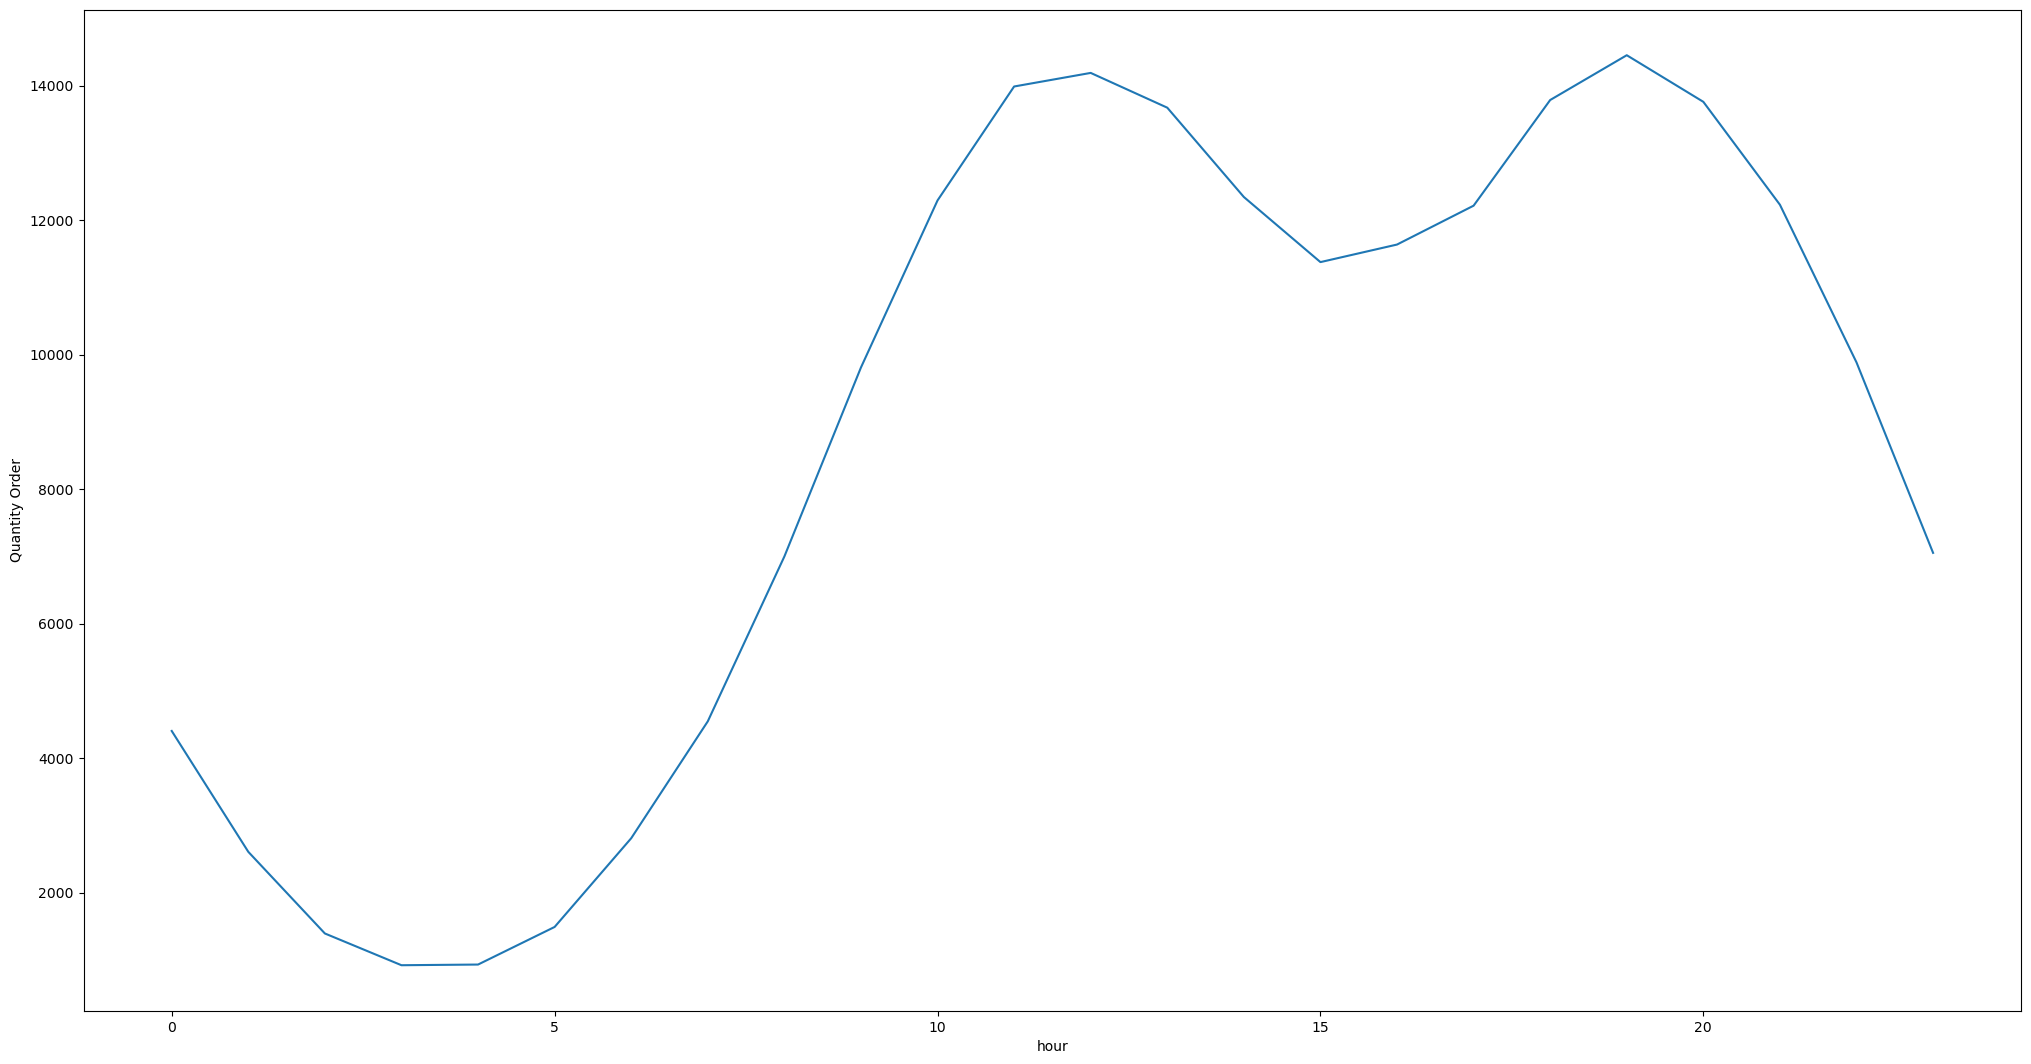

In [19]:
plt.figure(figsize=(25,13))
plt.plot(df_hour['hour'],df_hour['Quantity Ordered'])
plt.xlabel('hour')
plt.ylabel('Quantity Order')
plt.show()

# Weekday Sale

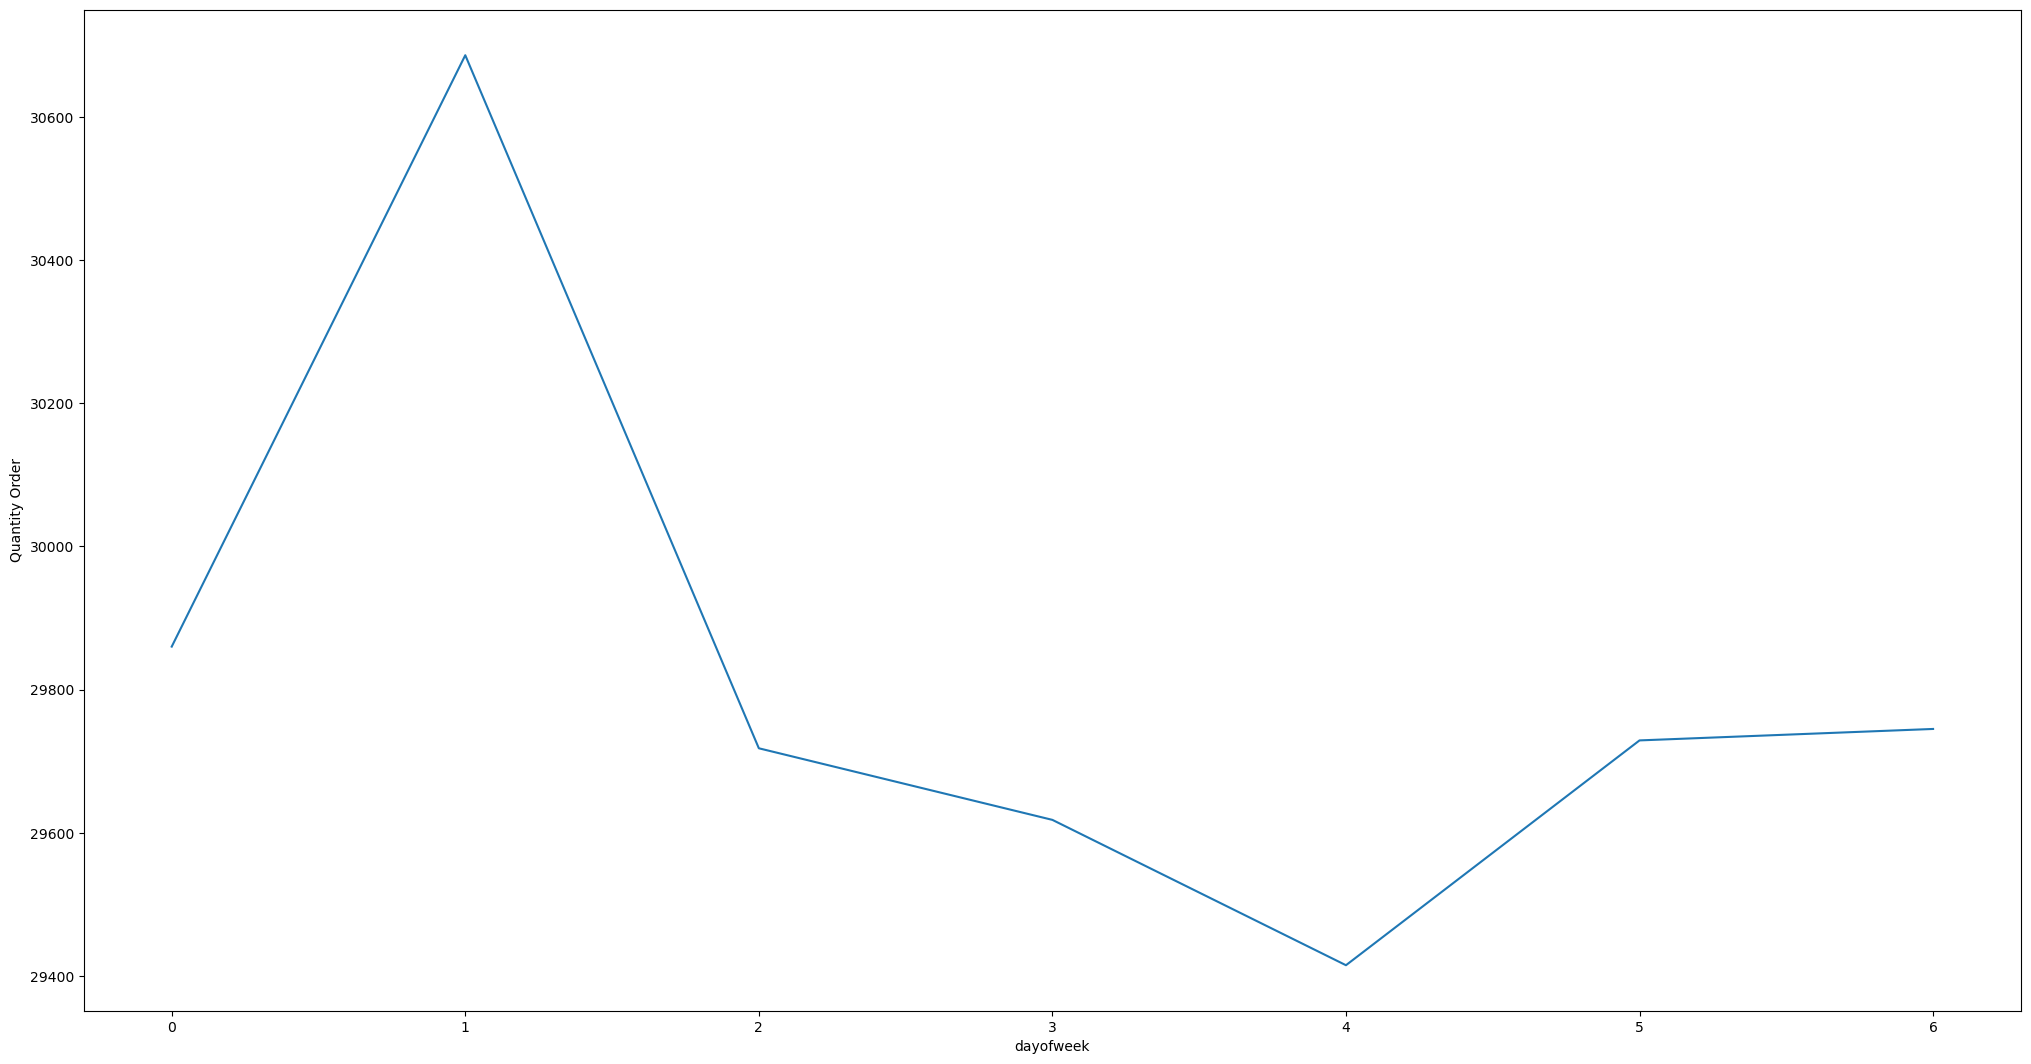

In [20]:
plt.figure(figsize=(25,13))
plt.plot(df_dayofweek['dayofweek'],df_dayofweek['Quantity Ordered'])
plt.xlabel('dayofweek')
plt.ylabel('Quantity Order')
plt.show()

In [21]:
df = df.reset_index().rename(columns={'Date': 'Order Date'})
df['Date'] = df['Order Date'].dt.date
df

,Order Date,Quantity Ordered,dayofweek,hour,quarter,month,year,Date
0,2019-01-01 03:00:00,2.0,1,3,1,1,2019,2019-01-01
1,2019-01-01 04:00:00,1.0,1,4,1,1,2019,2019-01-01
2,2019-01-01 05:00:00,1.0,1,5,1,1,2019,2019-01-01
3,2019-01-01 06:00:00,5.0,1,6,1,1,2019,2019-01-01
4,2019-01-01 07:00:00,16.0,1,7,1,1,2019,2019-01-01
...,...,...,...,...,...,...,...,...
8622,2019-12-31 19:00:00,64.0,1,19,4,12,2019,2019-12-31
8623,2019-12-31 20:00:00,68.0,1,20,4,12,2019,2019-12-31
8624,2019-12-31 21:00:00,49.0,1,21,4,12,2019,2019-12-31
8625,2019-12-31 22:00:00,37.0,1,22,4,12,2019,2019-12-31


In [22]:
df_diff = df.copy()
df_diff['Date'] = pd.to_datetime(df_diff['Date']).to_frame('Date')
df_diff.drop('Order Date',axis=1,inplace=True)
df_diff.drop('hour',axis=1,inplace=True)
df_diff

,Quantity Ordered,dayofweek,quarter,month,year,Date
0,2.0,1,1,1,2019,2019-01-01
1,1.0,1,1,1,2019,2019-01-01
2,1.0,1,1,1,2019,2019-01-01
3,5.0,1,1,1,2019,2019-01-01
4,16.0,1,1,1,2019,2019-01-01
...,...,...,...,...,...,...
8622,64.0,1,4,12,2019,2019-12-31
8623,68.0,1,4,12,2019,2019-12-31
8624,49.0,1,4,12,2019,2019-12-31
8625,37.0,1,4,12,2019,2019-12-31


In [23]:
# Calculate the total quantity ordered for each date and day of the week
quantity_total = df_diff.groupby(['Date', 'dayofweek'])['Quantity Ordered'].sum()

# Reset the index of quantity_total for easier merging
quantity_total = quantity_total.reset_index()

# Merge the results back to the original dataframe
df_diff = df_diff.merge(quantity_total, on=['Date', 'dayofweek'], how='left', suffixes=('', '_total'))

# Now, df_diff will have a new column called 'Quantity Ordered_total' which is the total for each date and day of the week

# If you don't need the original 'Quantity Ordered' column anymore:
df_diff.drop('Quantity Ordered', axis=1, inplace=True)

df_diff.drop_duplicates(inplace=True)

In [24]:
df_diff.reset_index().drop('index', axis=1, inplace=True)

# Feature engineering

In [25]:
# Feature engineering (You can customize this part)
df_diff['Rolling_Avg_7'] = df_diff['Quantity Ordered_total'].rolling(window=7).mean().shift(1)
df_diff['Rolling_Std_7'] = df_diff['Quantity Ordered_total'].rolling(window=7).std().shift(1)
df_diff['Lag_1'] = df_diff['Quantity Ordered_total'].shift(1)
df_diff['Lag_2'] = df_diff['Quantity Ordered_total'].shift(2)
df_diff['Lag_7'] = df_diff['Quantity Ordered_total'].shift(7)
df_diff['Is_Start_Month'] = (df_diff['Date'].dt.is_month_start).astype(int)
df_diff['Is_End_Month'] = (df_diff['Date'].dt.is_month_end).astype(int)
df_diff

,dayofweek,quarter,month,year,Date,Quantity Ordered_total,Rolling_Avg_7,Rolling_Std_7,Lag_1,Lag_2,Lag_7,Is_Start_Month,Is_End_Month
0,1,1,1,2019,2019-01-01,343.0,NaN,NaN,NaN,NaN,NaN,1,0
21,2,1,1,2019,2019-01-02,367.0,NaN,NaN,343.0,NaN,NaN,0,0
43,3,1,1,2019,2019-01-03,330.0,NaN,NaN,367.0,343.0,NaN,0,0
67,4,1,1,2019,2019-01-04,329.0,NaN,NaN,330.0,367.0,NaN,0,0
90,5,1,1,2019,2019-01-05,355.0,NaN,NaN,329.0,330.0,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8507,4,4,12,2019,2019-12-27,867.0,910.571429,38.806602,922.0,902.0,911.0,0,0
8531,5,4,12,2019,2019-12-28,928.0,904.285714,42.145440,867.0,922.0,874.0,0,0
8555,6,4,12,2019,2019-12-29,953.0,912.000000,40.591461,928.0,867.0,870.0,0,0
8579,0,4,12,2019,2019-12-30,925.0,923.857143,38.338095,953.0,928.0,987.0,0,0


# XG Boost

In [70]:
# Remove rows with missing values after feature engineering
df_diff.dropna(inplace=True)

# Split the data into training and testing sets
X = df_diff[["dayofweek", "month","quarter", "Is_Start_Month", "Is_End_Month", "Lag_1", "Lag_2", "Lag_7", "Rolling_Avg_7", "Rolling_Std_7"]]
y = df_diff["Quantity Ordered_total"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create and train the XGBoost model
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)

# Make predictions using XGBoost
y_pred = xgb_model.predict(X_test)
print(y_pred)
# Calculate the Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error:{mse}")

# Calculate the R-squared score
score_xgb = r2_score(y_test, y_pred)
print(f"R-squared Score: {score_xgb}")

[410.47903 504.16666 419.10138 683.15546 549.4652  677.5624  343.17596
 556.03937 433.14185 531.26654 590.0135  437.93842 432.5084  692.61334
 536.6664  615.4201  548.2894  501.73676 545.634   891.7727  530.7006
 438.3697  415.25467 490.8782  884.06665 450.53342 503.7652  653.1629
 399.5391  555.88495 448.59476 364.20972 880.2887  544.37335 638.9651
 508.6705  357.2199  879.326   686.37964 654.1728  548.5935  428.28467
 636.71094 679.66534 507.7039  420.19162 525.6209  346.14655 476.18802
 458.89258 703.1734  712.43414 407.2672  574.73553 873.55273 437.8458
 349.7054  535.101   543.8621  437.15958 542.20306 499.8263  413.8632
 536.3489  550.1117  644.24915 939.9829  543.3151  433.7368  708.4632
 893.0995  496.05026 639.6105  884.5882  510.02313 611.69904 519.67163
 498.74252 357.47147 533.8228  597.0318  356.81485 896.73987 513.3449
 635.3627  892.0176  504.4082  508.98975 681.6002  748.5758  542.1987
 609.565   920.31024 712.9588  439.54312 428.37497 346.00824 507.67578
 388.6823  735

# Random Forest Regressor

Mean Squared Error: 2406.9380796296296
R-squared Score: 0.9049964033693924


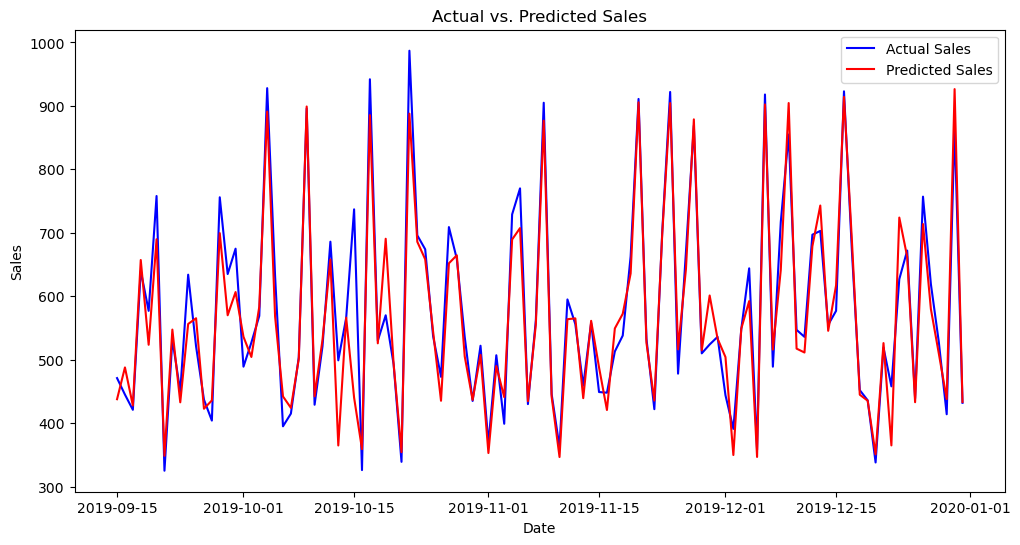

In [71]:
# Split the data into a training set and a test set
train_size = int(0.7 * len(df_diff))
train_set, test_set = df_diff[:train_size], df_diff[train_size:]

# Prepare the data for modeling
X = df_diff[["dayofweek", "month","quarter", "Is_Start_Month", "Is_End_Month", "Lag_1", "Lag_2", "Lag_7", "Rolling_Avg_7", "Rolling_Std_7"]]
y = df_diff["Quantity Ordered_total"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create and train a model (Random Forest Regressor)
model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate the R-squared score
score_rf = r2_score(y_test, y_pred)
print(f"R-squared Score: {score_rf}")

# Visualize actual vs. predicted sales
plt.figure(figsize=(12, 6))
plt.plot(test_set['Date'], y_test, label="Actual Sales", color="blue")
plt.plot(test_set['Date'], y_pred, label="Predicted Sales", color="red")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Actual vs. Predicted Sales")
plt.legend()
plt.show()

# Linear Regression

Mean Squared Error: 2173.3059672299473
R-squared Score: 0.9142180327724186


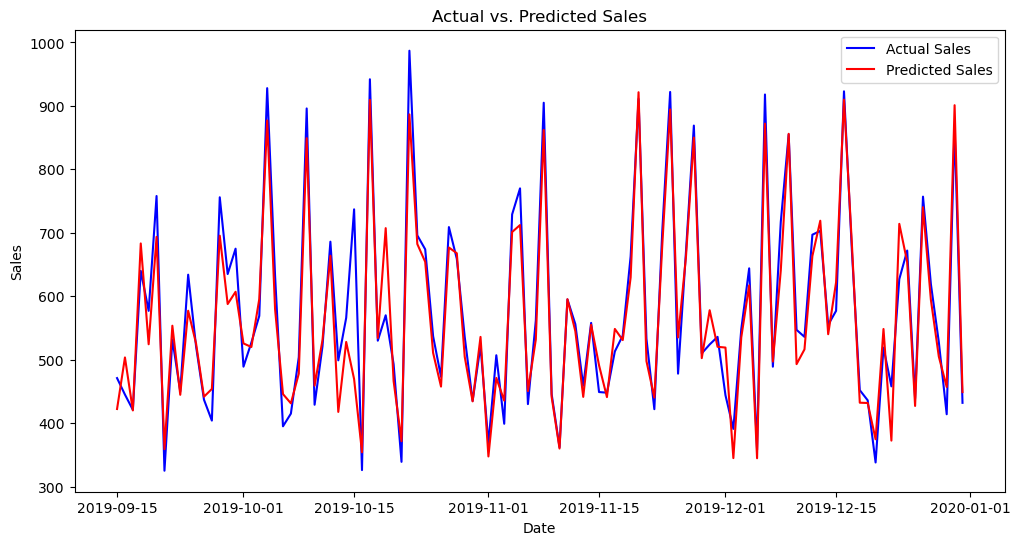

In [72]:
train_size = int(0.7 * len(df_diff))
train_set, test_set = df_diff[:train_size], df_diff[train_size:]

# Prepare the data for modeling
X = df_diff[["dayofweek", "month","quarter", "Is_Start_Month", "Is_End_Month", "Lag_1", "Lag_2", "Lag_7", "Rolling_Avg_7", "Rolling_Std_7"]]
y = df_diff["Quantity Ordered_total"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
lnr=LinearRegression()
lnr.fit(X_train,y_train)
lnr_pred= lnr.predict(X_test)

# Calculate the Mean Squared Error
mse = mean_squared_error(y_test, lnr_pred)
print(f"Mean Squared Error: {mse}")

# Calculate the R-squared score
score_lnr = r2_score(y_test, lnr_pred)
print(f"R-squared Score: {score_lnr}")

plt.figure(figsize=(12, 6))
plt.plot(test_set['Date'], y_test, label="Actual Sales", color="blue")
plt.plot(test_set['Date'], lnr_pred, label="Predicted Sales", color="red")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Actual vs. Predicted Sales")
plt.legend()
plt.show()

# K-Nearest neighbor 

In [107]:
# knr = KNeighborsRegressor()
# # Train Model
# knr.fit(X_train, y_train)

In [108]:
# knr_pred = knr.predict(X_test)
# knr_pred

In [109]:
# score_knr = metrics.r2_score(y_test, knr_pred)
# print(score_knr)

# Decision Tree

In [76]:
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)
tree_prd = tree.predict(X_test)
tree_prd

array([438., 507., 405., 593., 518., 709., 349., 613., 433., 543., 613.,
       419., 405., 695., 550., 588., 572., 449., 567., 870., 543., 427.,
       405., 497., 870., 426., 485., 636., 343., 558., 430., 349., 870.,
       485., 726., 510., 339., 870., 654., 680., 572., 432., 641., 652.,
       497., 436., 448., 339., 485., 456., 678., 678., 405., 550., 910.,
       426., 339., 550., 574., 427., 528., 450., 389., 543., 558., 568.,
       953., 557., 451., 726., 902., 541., 644., 878., 523., 605., 541.,
       510., 339., 528., 605., 323., 894., 500., 623., 870., 500., 449.,
       643., 766., 550., 613., 953., 726., 467., 451., 339., 485., 339.,
       721., 687., 433., 703., 540., 510., 438., 953., 433.])

In [77]:
score_tree = metrics.r2_score(y_test, tree_prd)
print(score_tree)

0.8529174511970039


# Comparing the best algorithm

In [111]:
algorithms = ["Linear Regression", "Random Forest", "XG Boost", "Decision tree"]
scores = [score_lnr, score_rf, score_xgb, score_tree] 

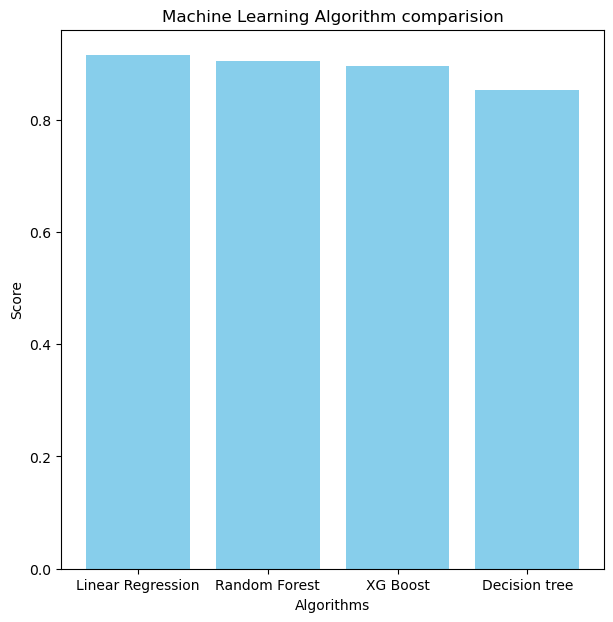

In [117]:
plt.figure(figsize=(7, 7))  # Adjust the figure size as needed

# Create the bar chart
plt.bar(algorithms, scores, color='skyblue')
plt.xlabel('Algorithms')
plt.ylabel('Score')
plt.title('Machine Learning Algorithm comparision')
plt.show()

# Model Prediction

In [106]:
import joblib as jb

In [81]:
jb.dump(xgb_model,'Sales_Predict')

['Sales_Predict']

In [82]:
model = jb.load("Sales_Predict")

In [83]:
df_diff.columns

Index(['dayofweek', 'quarter', 'month', 'year', 'Date',
       'Quantity Ordered_total', 'Rolling_Avg_7', 'Rolling_Std_7', 'Lag_1',
       'Lag_2', 'Lag_7', 'Is_Start_Month', 'Is_End_Month'],
      dtype='object')

In [93]:
df_diff.tail(8)

,dayofweek,quarter,month,year,Date,Quantity Ordered_total,Rolling_Avg_7,Rolling_Std_7,Lag_1,Lag_2,Lag_7,Is_Start_Month,Is_End_Month
8435,1,4,12,2019,2019-12-24,908.0,928.000000,66.590790,987.0,870.0,1042.0,0,0
8459,2,4,12,2019,2019-12-25,902.0,908.857143,43.674663,908.0,987.0,870.0,0,0
8483,3,4,12,2019,2019-12-26,922.0,913.428571,40.488093,902.0,908.0,942.0,0,0
8507,4,4,12,2019,2019-12-27,867.0,910.571429,38.806602,922.0,902.0,911.0,0,0
8531,5,4,12,2019,2019-12-28,928.0,904.285714,42.145440,867.0,922.0,874.0,0,0
8555,6,4,12,2019,2019-12-29,953.0,912.000000,40.591461,928.0,867.0,870.0,0,0
8579,0,4,12,2019,2019-12-30,925.0,923.857143,38.338095,953.0,928.0,987.0,0,0
8603,1,4,12,2019,2019-12-31,884.0,915.000000,26.720778,925.0,953.0,908.0,0,1


In [103]:
import pandas as pd
df_test = pd.DataFrame({
    'dayofweek':2,
    'month':1,
    'quarter':1,
    'Is_Start_Month':1,
    'Is_End_Month':0,
    'Lag_1':884.0,
    'Lag_2':925.0,
    'Lag_7':902.0,
    'Rolling_Avg_7':907,
    'Rolling_Std_7':27.02,
},index=[0])



In [104]:
result=model.predict(df_test)
result

array([707.67206], dtype=float32)

In [100]:
df_2020['Order Date']=pd.to_datetime(df_2020['Order Date']).dt.date
df_2020=df_2020.groupby('Order Date')['Quantity Ordered'].sum().reset_index()

In [101]:
df_2020

,Order Date,Quantity Ordered
0,2020-01-01,41.0
